Perform Hierarchical Drift-Diffusion Modeling of the StateSwitch Dynamic Responses using the HDDM toolbox

In [1]:
import hddm
print("HDDM version: "+ hddm.__version__)

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
print("Numpy version: "+ np.__version__) 

import scipy.io as io

import warnings
warnings.filterwarnings('ignore')
print("Important: Warnings disabled for improved clarity")

import pickle

def savePatch(self, fname):
    with open(fname, 'wb') as f:
        pickle.dump(self, f)

import os
dirname = os.path.realpath('../..')


The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
HDDM version: 0.8.0
Numpy version: 1.21.5
Important: Warnings disabled for improved clarity


/mnt/beegfs/home/kosciessa/.virtualenvs/hddm_env/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


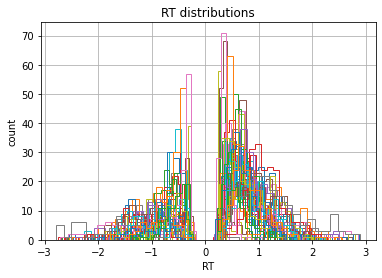

In [2]:
# get data from numpy structured array

group = 'OA'
modality = 'EEG'
params = 'v'

dataPath = os.path.join(dirname, 'data')
csvData = os.path.join(dataPath,'StateSwitchDynamicTrialData_'+modality+'_'+group+'.dat')
savePath = os.path.join(dataPath, 'hddm', group+'_'+modality+'_'+params)
if not os.path.exists(savePath):
    os.makedirs(savePath)

########################
## Load and flip data ##
########################

data = hddm.load_csv(csvData)
data.rename(columns={'acc':'response'}, inplace=True)
data.rename(columns={'subject':'subj_idx'}, inplace=True)

dataFlipped = hddm.utils.flip_errors(data)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in dataFlipped.groupby('subj_idx'):
    subj_data.rt.hist(bins=40, histtype='step', ax=ax)
    

In [3]:
model = hddm.HDDM(data, depends_on={'v': ['dim']}, p_outlier=.05)
model.find_starting_values()
model.sample(7000, burn=5000, dbname=os.path.join(savePath,'traces.db'), db='pickle')
fileName = 'model'
print('Model will be saved at: '+ os.path.join(savePath,fileName))
model.savePatch = savePatch(model, os.path.join(savePath,fileName))

 [-----------------100%-----------------] 7001 of 7000 complete in 6970.9 secModel will be saved at: /mnt/beegfs/home/LNDG/stateswitch/stsw_beh_task/hddm/data/hddm/OA_EEG_v/model


In [4]:
# save individual results as CSV
dataMat = model.get_traces()
fileName = 'data.csv'
print('Data will be saved at: '+ os.path.join(savePath,fileName))
dataMat.to_csv(os.path.join(savePath,fileName), sep='\t')

Data will be saved at: /mnt/beegfs/home/LNDG/stateswitch/stsw_beh_task/hddm/data/hddm/OA_EEG_v/data.csv


In [5]:
# extract posterior predictive check RT distributions for postHoc assessment
ppc_data = hddm.utils.post_pred_gen(model,samples=100)
fileName = 'ppc.csv'
print('Data will be saved at: '+ os.path.join(savePath,fileName))
ppc_data.to_csv(os.path.join(savePath,fileName), sep='\t')

 [-----------------101%-----------------] 215 of 212 complete in 392.3 secData will be saved at: /mnt/beegfs/home/LNDG/stateswitch/stsw_beh_task/hddm/data/hddm/OA_EEG_v/ppc.csv


In [6]:
# model = pickle.load(open(os.path.join(savePath,'model'), 'rb'))

Text(0.5, 1.0, 'YA: Posterior of drift-rate group means')

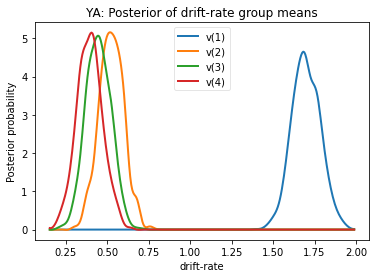

In [7]:
# drift rate v
v_11,v_12,v_13,v_14 = model.nodes_db.node[['v(1)', 'v(2)', 'v(3)','v(4)']]
hddm.analyze.plot_posterior_nodes([v_11,v_12,v_13,v_14])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('YA: Posterior of drift-rate group means')

Plotting a
Plotting a_std
Plotting v(1)
Plotting v(2)
Plotting v(3)
Plotting v(4)
Plotting v_std
Plotting t
Plotting t_std


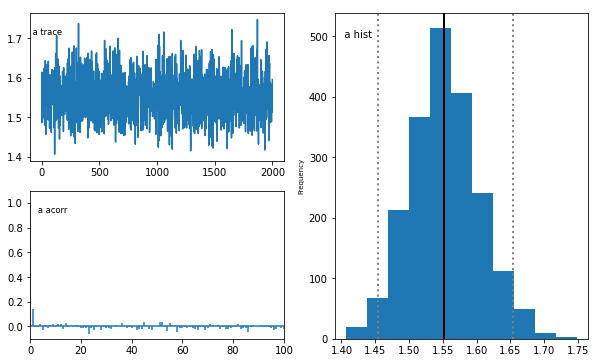

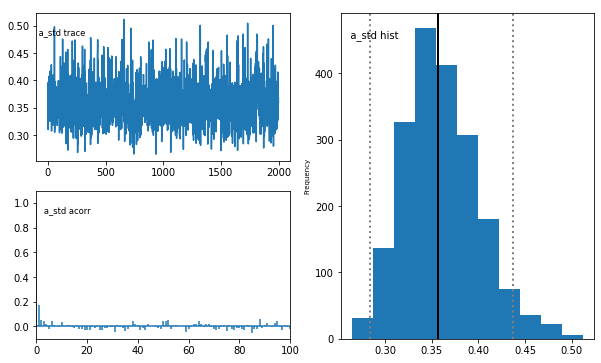

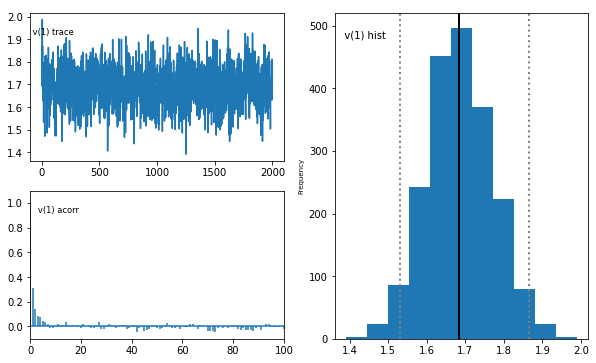

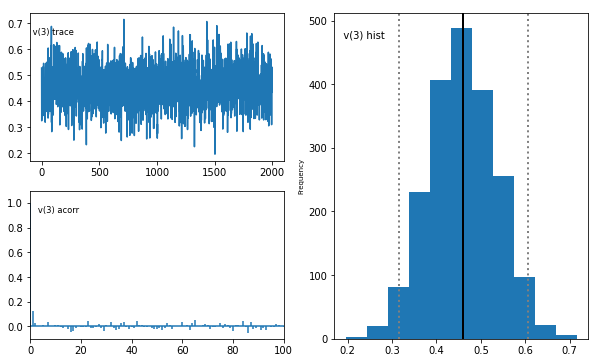

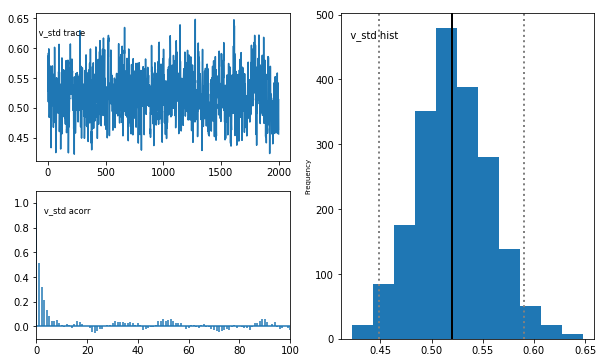

In [8]:
# posterior predictive check
#model.plot_posterior_predictive()
model.plot_posteriors()

In [9]:
print("Drift rate changes")
print("P(1 > 2)=",(v_11.trace() > v_12.trace()).mean())
print("P(2 > 3)=",(v_12.trace() > v_13.trace()).mean())
print("P(3 > 4)=",(v_13.trace() > v_14.trace()).mean())
print("")

Drift rate changes
P(1 > 2)= 1.0
P(2 > 3)= 0.767
P(3 > 4)= 0.682



In [10]:
print("Model DIC: %f" % model.dic)

Model DIC: 20706.805459
